In [19]:
import pyvisa
import numpy as np
import time
import pandas as pd
import os
import sys
import CVCommands
from os import path
from simple_pid import PID
from datetime import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from pyvisa import ResourceManager, constants
from usb.core import find as finddev
from IPython.display import clear_output

In [24]:
sampName = 'OPV1'
cellNum = '1'


fastScan = False #Uses a voltage fit to speed up scan time, if fit is not available one will be made

V_fitmax = 10 #Maximum Vsmu output
V_fitmin = -2 #Minimum Vsmu output
fitby = 'SMU' #'SMU' or 'CONTROL', fit by setting the value of the [SMU] or by [CONTROL]ling to setpoint value
                #fitting by SMU is much faster

#Values for CIGS fine scan
V_i = 0.6 #Initial bias V (V)
V_f = -1 #Final bias V (V)
V_step = 100 #Number of steps

Freq_i=2
Freq_f=6
Freq_step=5

amp=0.05

num_avg = 5 #Number of measurements to average

delay = .1 #Delay between changing to new value

holdbias = False #Toggle to hold device at bias before measurement
hold_val = V_i #Voltage to hold at in V
hold_time = 30 #Time to hold voltage in s

pulseScan = False #Measurement V pulse on or off
pulse_time = 10 #Pulse time in s

####################################################

#PID tuning parameters for V setpoint
Ku = 1.3
Tu = 1
CVCommands.P = 0.45*Ku    #3.06
CVCommands.I = 0.54*Ku/Tu    #2.8
CVCommands.D = 0.0

CVCommands.offset = 0.1 #Acceptable tolerance for voltage setpoint in V

CVCommands.reset_i = 0 #Subtract this value from voltage setpoint to improve PID speed
CVCommands.reset = 5 #Subtract value from setpoint after reset trigger

CVCommands.reset_val = 1000 #Trigger voltage setpoint reset after iterations
CVCommands.shutoff_val = 1000 #Max iterations before shutdown
CVCommands.num_avg = num_avg
CVCommands.mvavg_num = 20 #Number of points to calculate voltage setpoint moving average

CVCommands.v_ceiling = 35 #Max allowable voltage sent to SMU, maximum value 35

CVCommands.trig_delay = 0.1
CVCommands.meas_speed = 'SLOW2' #FAST, MED, SLOW, SLOW2
CVCommands.lowz = 'ON'

CVCommands.LCR_timeout = 60*1000



Voltage sweep:   0%|          | 0/100 [00:00<?, ?it/s]

DC Bias set to 0.6V                                               




Voltage sweep:   1%|          | 1/100 [00:06<10:45,  6.52s/it]

DC Bias set to 0.584V                                           




Voltage sweep:   2%|▏         | 2/100 [00:13<10:48,  6.62s/it]

DC Bias set to 0.568V                                           




Voltage sweep:   3%|▎         | 3/100 [00:19<10:29,  6.49s/it]

DC Bias set to 0.552V                                           




Voltage sweep:   4%|▍         | 4/100 [00:26<10:23,  6.50s/it]

DC Bias set to 0.535V                                           




Voltage sweep:   5%|▌         | 5/100 [00:32<10:14,  6.47s/it]

DC Bias set to 0.519V                                           




Voltage sweep:   6%|▌         | 6/100 [00:38<10:07,  6.46s/it]

DC Bias set to 0.503V                                           




Voltage sweep:   7%|▋         | 7/100 [00:45<09:56,  6.42s/it]

DC Bias set to 0.487V                                            




Voltage sweep:   8%|▊         | 8/100 [00:51<09:41,  6.32s/it]

DC Bias set to 0.471V                                           




Voltage sweep:   9%|▉         | 9/100 [00:57<09:29,  6.26s/it]

DC Bias set to 0.455V                                           




Voltage sweep:  10%|█         | 10/100 [01:03<09:10,  6.11s/it]

Frequency sweep:  80%|████████  | 4/5 [1:20:50<20:12, 1212.72s/it]


Interrupt


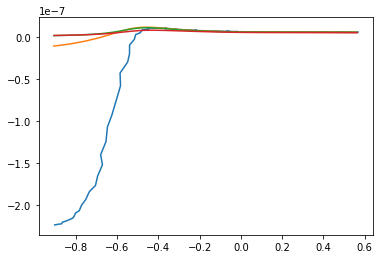

In [25]:
os.chdir('/home/pi/Desktop/CV')
foldname = datetime.today().strftime('%m-%d-%Y')
now = datetime.now()
currtime = now.strftime("%m%d%y%H%M")
month_format=datetime.today().strftime('%m-%Y')
currtime_format = now.strftime("%m/%d/%y %H:%M")

if os.path.isdir(month_format) is False:
    os.mkdir(month_format)
    os.chdir(month_format)
else:
    os.chdir(month_format)   

if os.path.isdir(foldname) is False:
    os.mkdir(foldname)

os.chdir(foldname)

CVFfoldname = ''.join(['CVF_',currtime])
if os.path.isdir(CVFfoldname) is False:
    os.mkdir(CVFfoldname)
os.chdir(CVFfoldname)

try:
    DMM.query('*IDN?')
except:
    rm = pyvisa.ResourceManager()
    rm.list_resources()
    DMMdev = finddev(idVendor=0x05e6, idProduct=0x2100) #Device ID for DMM
    DMMdev.reset() 
    DMM = rm.open_resource('USB0::1510::8448::1182494::0::INSTR')
    LCR = rm.open_resource('GPIB0::17::INSTR')
    SMU = rm.open_resource('GPIB0::24::INSTR')
  
    CVCommands.LCR = LCR
    CVCommands.SMU = SMU
    CVCommands.DMM = DMM
    CVCommands.SMU_configure()
    CVCommands.playstair()
    CVCommands.playon()

CVCommands.fastScan = fastScan
CVCommands.sampName = sampName
CVCommands.LCR_configure()
CVCommands.LCR_CGD()

error = False

time.sleep(1)
################################################

if fastScan == True:
    if path.exists(''.join(['/home/pi/Desktop/VoltageFits/','Vfitdata_',sampName])):
        CVCommands.fit_df = pd.read_csv(''.join(['/home/pi/Desktop/VoltageFits/','Vfitdata_',sampName]),sep='\t')
    else:
        CVCommands.voltFit(V_fitmin,V_fitmax,fitby)
        CVCommands.fit_df = pd.read_csv(''.join(['/home/pi/Desktop/VoltageFits/','Vfitdata_',sampName]),sep='\t') 


#Sets LCR oscilation voltage
CVCommands.set_oscVolt(amp)

try:
    start_time = time.time()
    for k in tqdm(np.logspace(Freq_i,Freq_f,Freq_step),desc='Frequency sweep'):
        freq = k

        CVCommands.setFreq(freq)

        now = datetime.now()
        currtime = now.strftime("%m%d%y%H%M")

        V_arr = []
        c_arr = []
        f_arr = []
        g_arr = []
        d_arr = []
        time_arr = []
        if holdbias is True:

            CVCommands.setBias(hold_val,True,fastScan)

            print('Waiting                                    ')
            time.sleep(hold_time)        

        for i in tqdm(np.linspace(V_i,V_f,V_step),desc=''.join(['Voltage sweep'])):

            CVCommands.setBias(i,True,fastScan)

            c, g, d = CVCommands.getData()

            V_arr.append(float(DMM.query(':READ?')))
            f_arr.append(freq)
            c_arr.append(c)
            g_arr.append(g)
            d_arr.append(d)
            
            end_time = time.time()
            time_tot = end_time-start_time
            time_arr.append(time_tot)
            if pulseScan == True:
                CVCommands.setBias(0,True,fastScan)
                DMM.query(':READ?')
                time.sleep(pulse_time)

        
        tempdict = {
            'DC Bias (V)' : V_arr,
            'Capacitance (F)' : c_arr,
            'Conductance (S)' : g_arr,
            'Dissipation (D)' : d_arr,
            'Frequency (Hz)' : f_arr,
            'Scan time (s)' : time_arr

        }



        info_labels = ['Sample Name: ','Cell Number: ','V start: ','V final: ','V steps: ','Freq start: ','Freq final: ','Freq steps: ','AC amp: ','Start time: ']
        info_data = [sampName,cellNum,V_i,V_f,V_step,10**Freq_i,10**Freq_f,Freq_step,amp,currtime_format]

        dictlen = len(tempdict[list(tempdict.keys())[0]])
        infolen = len(info_data)

        if dictlen >= infolen:
            info_labels = info_labels+[np.nan]*(dictlen-infolen)
            info_data = info_data+[np.nan]*(dictlen-infolen)
        else:
            for i in tempdict:
                tempdict[i] = tempdict[i]+[np.nan]*(infolen-dictlen)

        tempdict['Info1'] = info_labels
        tempdict['Info2'] = info_data
        
        print('Saving as: '+''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz']))
        globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])] = pd.DataFrame(tempdict)
        globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])].to_csv(''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz']),sep='\t')

        CVCommands.offBias()


        print('Measurement complete')
        print('Data saved')

        plt.plot(globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])]['DC Bias (V)']
                 ,globals()[''.join([sampName,'_CV','_',currtime,'_',"{:.0f}".format(freq/1000),'kHz'])]['Capacitance (F)'])
        clear_output(wait=True)
except KeyboardInterrupt as e:
    CVCommands.offBias()
    error = True
    print(e)
    print('Interrupt')
LCR.write(':TRIG INT')  
if error == False:
    time.sleep(0.5)
    CVCommands.playchest()
else:
    CVCommands.playrand(10,0.05)